In this notebook we implement Grover's search to locate two data entries in eight total entries. The data is saved in qRAM with 3-qubit address register. It is fanned out to 8 memory locations usign 8-qubit fanout register. Memory locations are read out by the 4-qubit readout register after which the data of interest is selected. Input data to be stored in the memory is [1,5,7, 10, 0, 0, 0, 0] where the binary forms of the entries are used. 
After uncomputing the readout and the fanout, the Oracle does the job that is expected of it in the Grover's algorithm. A state amplification circuit then rotates the state of the address register close to a linear superposition of states such that each of these states point to the location of the marked strings. 

In [1]:
# initialization
import numpy as np

# import Qiskit
from qiskit import IBMQ, BasicAer , Aer, assemble , transpile
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import Permutation

# import basic plotting tools
from qiskit.visualization import plot_histogram
%matplotlib inline

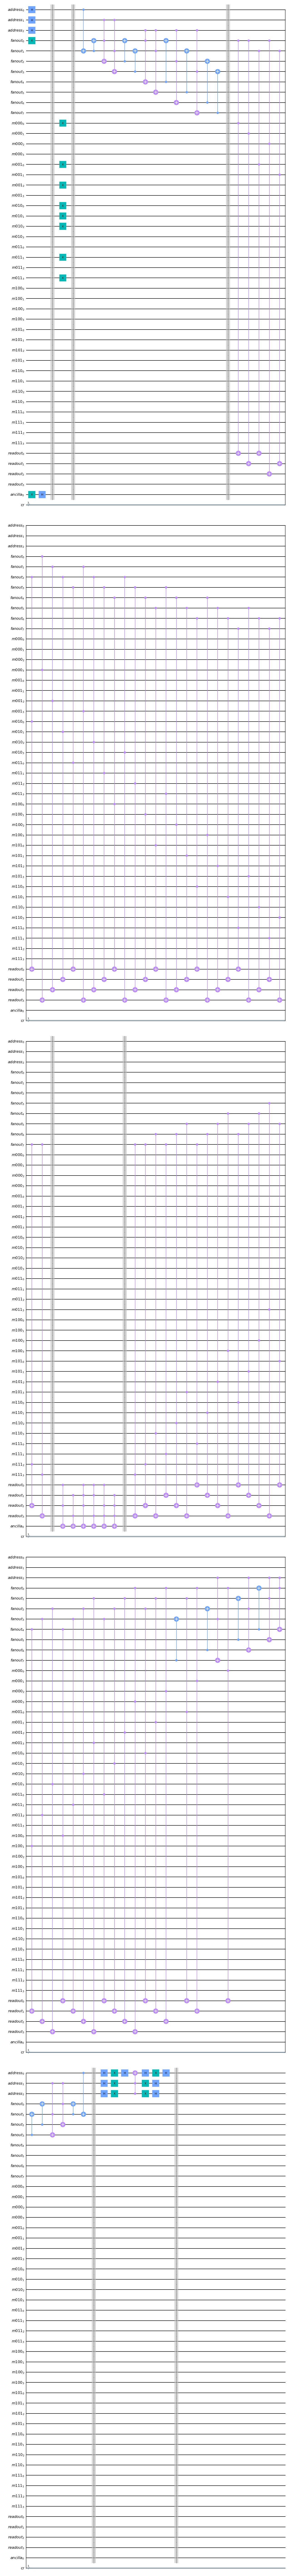

In [2]:
#qRAM circuit

ar = QuantumRegister(3, "address")   #address register
fo = QuantumRegister(8, "fanout")    # fanout register 
ro = QuantumRegister(4,"readout")     # readout register
anc = QuantumRegister(1,"ancilla")    #Ancilla to be used in the oracle

mr0 = QuantumRegister(4,"m000")   #Memory registers. Each one encodes a 4 bit data.
mr1 = QuantumRegister(4,"m001")
mr2 = QuantumRegister(4,"m010")
mr3 = QuantumRegister(4,"m011")
mr4 = QuantumRegister(4,"m100")
mr5 = QuantumRegister(4,"m101")
mr6 = QuantumRegister(4,"m110")
mr7 = QuantumRegister(4,"m111")

 
cr = ClassicalRegister(3,"cr")  #Classical register for measuring the state of address register after one Grover iteration

qRAM = QuantumCircuit(ar,fo,mr0,mr1,mr2,mr3,mr4,mr5,mr6,mr7,ro,anc,cr)


#Initialize the first qubit of the fanout regsiter in the |1> state
qRAM.x(fo[0])

#Initialize the ancilla qubit in the |-> state
qRAM.x(anc[0])
qRAM.h(anc[0])

#Initialize the address register to get a uniform superposition of all the states, ie., SIGMA |x> for x = 0 to 3
qRAM.h(ar[0])
qRAM.h(ar[1])
qRAM.h(ar[2])

qRAM.barrier()
##################################################################
#Feed in data to the memory register. Need a program to convert vector input to string input. For now
#we just do it by hand in the individual memory locations

#feed in integer 1 in mr0
qRAM.x(mr0[0])

#feed in integer 5 in mr1
qRAM.x(mr1[0])
qRAM.x(mr1[2])

#feed in integer 7 in mr2
qRAM.x(mr2[0])
qRAM.x(mr2[1])
qRAM.x(mr2[2])

#feed in integer 10 in mr3
qRAM.x(mr3[1])
qRAM.x(mr3[3])

#feed in arbitrary integers in mr4 mr5 mr6 mr7. We leave them as 0000 for now.

##################################################################

qRAM.barrier()

#Fanout process
qRAM.cx(ar[0],fo[1])
qRAM.cx(fo[1],fo[0])

qRAM.mct([ar[1],fo[0]],fo[2])  #Multi-controlled Toffoli to implement CCX gate
qRAM.mct([ar[1],fo[1]],fo[3])
qRAM.cx(fo[2],fo[0])
qRAM.cx(fo[3],fo[1])

qRAM.mct([ar[2],fo[0]],fo[4])
qRAM.mct([ar[2],fo[1]],fo[5])
qRAM.mct([ar[2],fo[2]],fo[6])
qRAM.mct([ar[2],fo[3]],fo[7])
qRAM.cx(fo[4],fo[0])
qRAM.cx(fo[5],fo[1])
qRAM.cx(fo[6],fo[2])
qRAM.cx(fo[7],fo[3])



qRAM.barrier()

#Readout process
qRAM.mct([fo[0],mr0[0]],ro[0])
qRAM.mct([fo[0],mr0[1]],ro[1])
qRAM.mct([fo[0],mr0[2]],ro[2])
qRAM.mct([fo[0],mr0[3]],ro[3])



qRAM.mct([fo[1],mr1[0]],ro[0])
qRAM.mct([fo[1],mr1[1]],ro[1])
qRAM.mct([fo[1],mr1[2]],ro[2])
qRAM.mct([fo[1],mr1[3]],ro[3])



qRAM.mct([fo[2],mr2[0]],ro[0])
qRAM.mct([fo[2],mr2[1]],ro[1])
qRAM.mct([fo[2],mr2[2]],ro[2])
qRAM.mct([fo[2],mr2[3]],ro[3])


qRAM.mct([fo[3],mr3[0]],ro[0])
qRAM.mct([fo[3],mr3[1]],ro[1])
qRAM.mct([fo[3],mr3[2]],ro[2])
qRAM.mct([fo[3],mr3[3]],ro[3])


qRAM.mct([fo[4],mr4[0]],ro[0])
qRAM.mct([fo[4],mr4[1]],ro[1])
qRAM.mct([fo[4],mr4[2]],ro[2])
qRAM.mct([fo[4],mr4[3]],ro[3])

qRAM.mct([fo[5],mr5[0]],ro[0])
qRAM.mct([fo[5],mr5[1]],ro[1])
qRAM.mct([fo[5],mr5[2]],ro[2])
qRAM.mct([fo[5],mr5[3]],ro[3])

qRAM.mct([fo[6],mr6[0]],ro[0])
qRAM.mct([fo[6],mr6[1]],ro[1])
qRAM.mct([fo[6],mr6[2]],ro[2])
qRAM.mct([fo[6],mr6[3]],ro[3])

qRAM.mct([fo[7],mr7[0]],ro[0])
qRAM.mct([fo[7],mr7[1]],ro[1])
qRAM.mct([fo[7],mr7[2]],ro[2])
qRAM.mct([fo[7],mr7[3]],ro[3])



qRAM.barrier()

## Now we do two-qubit Toffolis on the readout register to mark the states 0101 and 1010
# However, it marks other states too that would be taken care of shortly using four qubit Toffoli gates.
qRAM.mct([ro[0],ro[2]],anc[0])  
qRAM.mct([ro[1],ro[3]],anc[0])

#Four qubit Toffolis make sure that no other states except 0101 and 1010 remain marked
qRAM.mct([ro[0],ro[1], ro[2]],anc[0])  
qRAM.mct([ro[0],ro[1], ro[3]],anc[0])  
qRAM.mct([ro[0],ro[2], ro[3]],anc[0])  
qRAM.mct([ro[1],ro[2], ro[3]],anc[0])  

qRAM.barrier()


#~~~~~~~~~~~~~~~~~~~~~~~~~
# Now we need to uncompute
#~~~~~~~~~~~~~~~~~~~~~~~~~
## Uncompute the readout
qRAM.mct([fo[7],mr7[3]],ro[3])
qRAM.mct([fo[7],mr7[2]],ro[2])
qRAM.mct([fo[7],mr7[1]],ro[1])
qRAM.mct([fo[7],mr7[0]],ro[0])


qRAM.mct([fo[6],mr6[3]],ro[3])
qRAM.mct([fo[6],mr6[2]],ro[2])
qRAM.mct([fo[6],mr6[1]],ro[1])
qRAM.mct([fo[6],mr6[0]],ro[0])


qRAM.mct([fo[5],mr5[3]],ro[3])
qRAM.mct([fo[5],mr5[2]],ro[2])
qRAM.mct([fo[5],mr5[1]],ro[1])
qRAM.mct([fo[5],mr5[0]],ro[0])


qRAM.mct([fo[4],mr4[3]],ro[3])
qRAM.mct([fo[4],mr4[2]],ro[2])
qRAM.mct([fo[4],mr4[1]],ro[1])
qRAM.mct([fo[4],mr4[0]],ro[0])


qRAM.mct([fo[3],mr3[3]],ro[3])
qRAM.mct([fo[3],mr3[2]],ro[2])
qRAM.mct([fo[3],mr3[1]],ro[1])
qRAM.mct([fo[3],mr3[0]],ro[0])


qRAM.mct([fo[2],mr2[3]],ro[3])
qRAM.mct([fo[2],mr2[2]],ro[2])
qRAM.mct([fo[2],mr2[1]],ro[1])
qRAM.mct([fo[2],mr2[0]],ro[0])


qRAM.mct([fo[1],mr1[3]],ro[3])
qRAM.mct([fo[1],mr1[2]],ro[2])
qRAM.mct([fo[1],mr1[1]],ro[1])
qRAM.mct([fo[1],mr1[0]],ro[0])


qRAM.mct([fo[0],mr0[3]],ro[3])
qRAM.mct([fo[0],mr0[2]],ro[2])
qRAM.mct([fo[0],mr0[1]],ro[1])
qRAM.mct([fo[0],mr0[0]],ro[0])


## Uncompute the fanout
qRAM.cx(fo[7],fo[3])
qRAM.cx(fo[6],fo[2])
qRAM.cx(fo[5],fo[1])
qRAM.cx(fo[4],fo[0])

qRAM.mct([ar[2],fo[3]],fo[7])
qRAM.mct([ar[2],fo[2]],fo[6])
qRAM.mct([ar[2],fo[1]],fo[5])
qRAM.mct([ar[2],fo[0]],fo[4])

qRAM.cx(fo[3],fo[1])
qRAM.cx(fo[2],fo[0])
qRAM.mct([ar[1],fo[1]],fo[3])
qRAM.mct([ar[1],fo[0]],fo[2]) 

qRAM.cx(fo[1],fo[0])
qRAM.cx(ar[0],fo[1])

qRAM.barrier()

####
#Now we apply three-qubit diffuser to the address register. Note that the diffuser should be applied after the uncomputation.
qRAM.h(ar[0])
qRAM.h(ar[1])
qRAM.h(ar[2])

qRAM.x(ar[0])
qRAM.x(ar[1])
qRAM.x(ar[2])

qRAM.h(ar[0])      # These three steps apply CCZ to 0 qubit controlled by 1 and 2
qRAM.mct([ar[1],ar[2]],ar[0])
qRAM.h(ar[0])

qRAM.x(ar[0])
qRAM.x(ar[1])
qRAM.x(ar[2])

qRAM.h(ar[0])
qRAM.h(ar[1])
qRAM.h(ar[2])

qRAM.barrier()








qRAM.draw()


In [6]:
## Measure the address register to see the states
qRAM.measure(ar[0],cr[0])
qRAM.measure(ar[1],cr[1])
qRAM.measure(ar[2],cr[2])

simulator = Aer.get_backend('qasm_simulator')

qRAM=transpile(qRAM, simulator)

qobj = assemble(qRAM)
result = simulator.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)


QiskitError: 'ERROR:  [Experiment 0] QasmSimulator: Insufficient memory for 48-qubit circuit using "statevector" method. You could try using the "matrix_product_state" or "extended_stabilizer" method instead. ,  ERROR: QasmSimulator: Insufficient memory for 48-qubit circuit using "statevector" method. You could try using the "matrix_product_state" or "extended_stabilizer" method instead.'